In [1]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np

dl = DataLoader("/home/panda/rf_data/")

picmus_names = [
    "contrast_speckle_expe_dataset_rf",
    "contrast_speckle_simu_dataset_rf",
    "resolution_distorsion_expe_dataset_rf",
    "resolution_distorsion_simu_dataset_rf",
    "carotid_cross_expe_dataset_rf",
    "carotid_long_expe_dataset_rf"
]

#picmus_names = [ "contrast_speckle_expe_dataset_rf" ]


nz = 1024
nx = 512

#nz = 2048
#nx = 256

device = "cuda"
dtype = torch.float32

In [2]:
from deep_bf.wrapper import BenchmarkWrapper

bf_names = [
    "DASGridSample",
    "DASManual",
    "FDMAS"
]

bf_names = ["FDMAS"]

output = {}
for name in picmus_names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")
    angles_idx = np.arange(pw.n_angles)

    f_num = 1.75
    window = "tukey25"

    bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
    output[name] = bw.compute_reconstructions()


contrast_speckle_expe_dataset_rf
contrast_speckle_simu_dataset_rf
resolution_distorsion_expe_dataset_rf
resolution_distorsion_simu_dataset_rf
carotid_cross_expe_dataset_rf
carotid_long_expe_dataset_rf


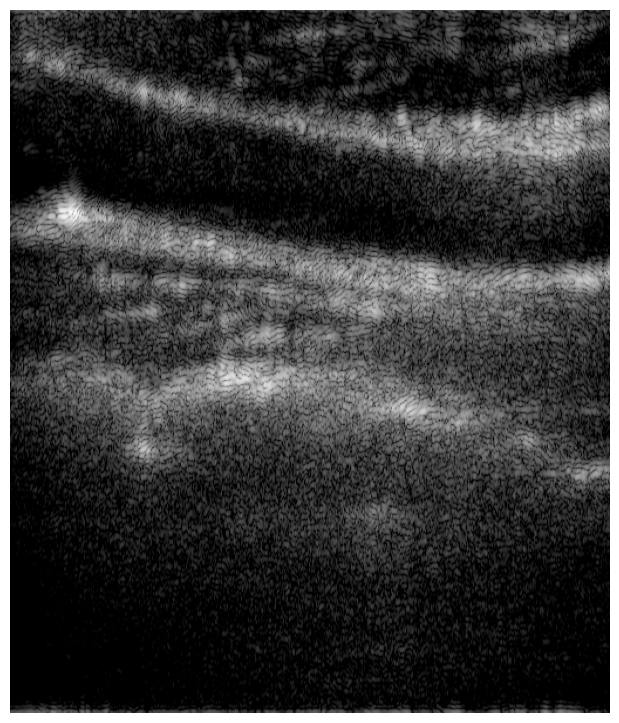

In [7]:
import matplotlib.pyplot as plt

picmus_idx = 5
bf_idx = 0
o = output[picmus_names[picmus_idx]][bf_names[bf_idx]]

vmin = -60
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = o.get_bmode(vmin=vmin, vmax=vmax)
extent = (o.xlims[0], o.xlims[-1], o.zlims[-1], o.zlims[0])


ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()

In [73]:
from deep_bf.beamformers import get_freqs, pass_band_filter

a, c, N = pw.data.shape
print(a, c, N)

freqs = get_freqs(pw.fs, pw.fc, BW=0.7, for_dmas=True)
print(freqs)

H = pass_band_filter(N, freqs, "tukey25", device=device, dtype=dtype)
print(H.shape)

75 128 1536
(20832000.0, np.float64(6770400.0), np.float64(14061600.0))
torch.Size([1536])
